In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpz07gjerj/pubring.gpg' created
gpg: /tmp/tmpz07gjerj/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!ls drive/bowl/models

albunet32.pth		    starterkit2.pth
albunet.pth		    starterkit_albunet.pth
albustarterkit_albunet.pth  starterkit.pth
starterkit2cc2mod1.pth	    starter_starterkit_albunet.pth
starterkit2cc2.pth	    starterstarterkit_albunet.pth
starterkit2cc.pth	    unet16.pth


In [0]:
!mkdir bowl/

In [0]:
!mkdir bowl/stage1_train/

In [0]:
!mkdir bowl/stage1_test/

In [0]:
!unzip drive/bowl/stage1_train.zip -d bowl/stage1_train/

In [0]:
!unzip drive/bowl/stage1_test.zip -d bowl/stage1_test/

In [9]:
!pip install telepyth

  Running setup.py bdist_wheel for telepyth ... - done
  Stored in directory: /content/.cache/pip/wheels/cc/de/cb/7b37e1991ad8586cc8e8be593c65e6bfc92c1f485442aae3bc
Successfully built telepyth


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
import pandas as pd
import numpy as np

import cv2
import os

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
import matplotlib.cm as cm  

%matplotlib inline

In [0]:
from torchvision import transforms, utils
from skimage import io, transform

In [0]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def iou_t(target, pred):
  target_y = label(target > 0.5)
  pred_y = label(pred > 0.5)
  true_objs = len(np.unique(target_y))
  pred_objs = len(np.unique(pred_y))
  intersection = np.histogram2d(target_y.flatten(),
                                pred_y.flatten(),
                                bins=(true_objs, pred_objs))[0]
  
  area_true = np.histogram(target_y, bins = true_objs)[0]
  area_pred = np.histogram(pred_y, bins = pred_objs)[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)
  
  union = area_true + area_pred - intersection
  
  intersection = intersection[1:,1:]
  union = union[1:,1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  
  prec = []
  for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    prec.append(p)
  return np.mean(prec)

In [0]:
def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None
  
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img
      
def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data
  
def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)<cutoff else x, imgs)))
    return normalize(imgs)

In [0]:
def process(img_rgb):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

In [0]:
class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

In [0]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

In [0]:
class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


In [0]:
class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=True, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        #print("input size: ", x.size())
        conv1 = self.conv1(x)
        #print("conv1 size: ", conv1.size())
        conv2 = self.conv2(conv1)
        #print("conv2 size: ", conv2.size())
        conv3 = self.conv3(conv2)
        #print("conv3 size: ", conv3.size())
        conv4 = self.conv4(conv3)
        #print("conv4 size: ", conv4.size())
        conv5 = self.conv5(conv4)
        #print("conv5 size: ", conv5.size())

        center = self.center(self.pool(conv5))
        #print("center size: ", center.size())

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        #print("dec5 size: ", dec5.size())

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = self.final(dec0)
        else:
            x_out = self.final(dec0)

        return x_out

In [0]:

from torch.utils.data import *
from skimage.transform import resize
class DSB2018Dataset(Dataset):
    def __init__(self, root_dir, img_id, train=True, transform=None):
        """
        Args:
        :param root_dir (string): Directory with all the images
        :param img_id (list): lists of image id
        :param train: if equals true, then read training set, so the output is image, mask and imgId
                      if equals false, then read testing set, so the output is image and imgId
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.img_id = img_id
        self.train = train
        self.transform = transform
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
          self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            
            #original_h, original_w = img.shape[0], img.shape[1]
            #img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            masks = [cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]]
            mask = sum(masks)
            #centers = []
            #for m in masks:
            #  centers.append(get_center(m))
            #mask_center = sum(centers)
            #mask_contour = get_contour(msk)
            
            #mask = resize(mask, (IMG_H, IMG_W), mode='constant')
            #mask_contour = np.expand_dims(mask_contour, -1)
            #mask_center = np.expand_dims(mask_center, -1)
            #mask_contour = np.expand_dims(np.swapaxes(mask_contour, 2, 0), 0) / 255.0
            #mask_center = np.expand_dims(np.swapaxes(mask_center, 2, 0), 0) / 255.0
            mask = np.expand_dims(mask, -1)
            mask = np.expand_dims(np.swapaxes(mask, 2, 0), 0) / 255.0
            img = np.expand_dims(np.swapaxes(img, 2, 0), 0) / 255.0
            sample = [torch.FloatTensor(img), torch.FloatTensor(mask)]
          
        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            
            original_h, original_w = img.shape[0], img.shape[1]
            #img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            img = np.expand_dims(np.swapaxes(img, 2, 0), 0) / 255.0
            #size = (img.shape[0],img.shape[1])  # (Height, Weidth)
            sample = [torch.FloatTensor(img), self.img_id[idx], original_h, original_w]
            
        if self.transform:
            sample =  self.transform(sample)
        return sample

In [0]:
IMG_H = 256
IMG_W = 256
class DSB2018Dataset_6D(Dataset):
    def __init__(self, root_dir, img_id, train=True, transform=None):
        """
        Args:
        :param root_dir (string): Directory with all the images
        :param img_id (list): lists of image id
        :param train: if equals true, then read training set, so the output is image, mask and imgId
                      if equals false, then read testing set, so the output is image and imgId
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.img_id = img_id
        self.train = train
        self.transform = transform
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
          self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            
            #original_h, original_w = img.shape[0], img.shape[1]
            #img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            masks = [cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]]
            mask = sum(masks) #FOR STAS: Here is a mask reading and center+contour extraction
            centers = []
            for m in masks:
              centers.append(get_center(m))#works only for single mask file(not for the sum of masks)
            mask_center = sum(centers)
            mask_contour = get_contour(mask) #works for sum of masks(but may be better for single mask file, need tests)
            
            #mask_center = resize(mask_center, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            #mask_contour = resize(mask_contour, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            #mask = resize(mask, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            
            #mask = resize(mask, (IMG_H, IMG_W), mode='constant')
            mask_contour = np.expand_dims(mask_contour, -1)
            mask_center = np.expand_dims(mask_center, -1)
            
            
            mask_contour = np.swapaxes(mask_contour, 2, 0) / 255.0
            mask_center = np.swapaxes(mask_center, 2, 0) / 255.0
            
            mask = np.expand_dims(mask, -1)
            mask = np.swapaxes(mask, 2, 0) / 255.0
            
            img = np.swapaxes(img, 2, 0) / 255.0
            #print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            sample = torch.FloatTensor(np.stack((img[0], img[1], img[2], mask[0] > 0, mask_center[0] > 0, mask_contour[0] > 0)))
            
          
        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            
            original_h, original_w = img.shape[0], img.shape[1]
            img = resize(img, (IMG_H, IMG_W), mode='constant', preserve_range=True)
            
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            img = np.expand_dims(np.swapaxes(img, 2, 0), 0) / 255.0
            #size = (img.shape[0],img.shape[1])  # (Height, Weidth)
            sample = [torch.FloatTensor(img), self.img_id[idx], original_h, original_w]
            
        if self.transform:
            sample =  self.transform(sample)
        return sample

In [0]:
class LossBinary:
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [0]:
class DanillTransform:
    def __init__(self, trans, prob=1., instruction=(True, True, False, False)):
        self.trans = trans
        self.prob = prob
        self.x_in, self.mask_in, self.center_in, self.bound_in = instruction

    def __call__(self, x, mask, center, bound):

        if True:
            if self.x_in:
                x = self.trans(x)
            if self.mask_in:
                mask = self.trans(mask)
            if self.center_in:
                center = self.trans(center)
            if self.bound_in:
                bound = self.trans(bound)
        return x, mask, center, bound

In [0]:
class UnetTansformation:
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, img):
        shape = img.shape

        if (shape[0] % 64 == 0) and (shape[1] % 64 == 0):
            return img

        indention_0 = 64 - shape[0] % 64
        indention_1 = 64 - shape[1] % 64

        indented_img = np.zeros((shape[0] + indention_0, shape[1] + indention_1, shape[2])).astype(np.uint8)
        indented_img[indention_0 // 2:-(indention_0 - indention_0 // 2), indention_1 // 2:-(indention_1 - indention_1 // 2), :] = img
        return indented_img

      
def back_shaper(img,shape:tuple):
        if (shape[0] % 32 == 0) and (shape[1] % 32 == 0):
            return img

        indention_0 = 32 - shape[0] % 32
        indention_1 = 32 - shape[1] % 32
        
        return img[indention_0 // 2:-(indention_0 - indention_0 // 2), indention_1 // 2:-(indention_1 - indention_1 // 2), :]
      
      
      
def unet_deconstructor(dataset, tensor, dirr = '../data/stage1_train/'):
    shapes = []
    dec_images = []
    
    for ids in dataset.img_id:
        img_dir = os.path.join(dirr, ids, 'images',ids + '.png')
        shapes.append(cv2.imread(img_dir).shape)
        
    for i in range(len(dataset)):
        dec_images.append(back_shaper(tensor[i].permute(1,2,0).numpy(),shapes[i]))
    
    return dec_images

In [0]:
class DatasetV2():
    def __init__(self, root_dir, img_id, transform=None, train=True):
        self.root_dir = root_dir
        self.img_id = img_id
        self.transform = transform
        self.train = train
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
            self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
    
    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            masks = [cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]]
            mask = sum(masks) #FOR STAS: Here is a mask reading and center+contour extraction
            centers = []
            for m in masks:
                centers.append(get_center(m))#works only for single mask file(not for the sum of masks)
            mask_center = sum(centers)
            mask_contour = get_contour(mask) #works for sum of masks(but may be better for single mask file, need tests)
            
            mask_contour = np.expand_dims(mask_contour, -1)
            mask_center = np.expand_dims(mask_center, -1)
            mask = np.expand_dims(mask, -1)
            
            mask[mask > 0.00001] = 255
            #print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            img, mask, mask_center, mask_contour = self.transform(img, mask, mask_center, mask_contour)
            img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0] #return_to_RGB
            #print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            mask = np.swapaxes(mask, 2, 0) / 255.0
            img = np.swapaxes(img, 2, 0) / 255.0
            mask_contour = np.swapaxes(mask_contour, 2, 0) / 255.0
            mask_center = np.swapaxes(mask_center, 2, 0) / 255.0
            
            #print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            sample = torch.FloatTensor(np.stack((img[0], img[1], img[2], mask[0], mask_center[0], mask_contour[0])))
            
          
        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            shape = img.shape
            print(shape)
            img = self.transform(img)
            img = np.swapaxes(img, 2, 0) / 255.0
            print(img.shape)
            sample = torch.FloatTensor(np.stack((img[0], img[1], img[2]))) # probably big crutch
        return sample
        
    def __len__(self):
        return len(self.img_id)

In [0]:
model_path = "drive/bowl/models/"
submission_path = "drive/bowl/submissions/"
model_name = "albunet_resize"
model_file = model_name + '.pth'
submission_file = model_name + '.csv'

In [0]:
TRAIN_DIR = 'bowl/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

In [0]:
TEST_DIR = 'bowl/stage1_test/'
test_ids = os.listdir(TEST_DIR)
test_images = [os.path.join(TEST_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test_ids]

In [0]:
from scipy import ndimage as ndi
def get_contour(img):
    img_contour = np.zeros_like(img)
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(img_contour, contours, -1, (255, 255, 255), 2)
    return img_contour
  
def get_center(img):
    img_center = np.zeros_like(img)
    y, x = ndi.measurements.center_of_mass(img)
    cv2.circle(img_center, (int(x), int(y)), 4, (255, 255, 255), -1)
    return img_center

In [0]:
starter_model = nn.Sequential(nn.Conv2d(3, 16, (11, 11), padding=5),
                      nn.ReLU(),
                      nn.Conv2d(16, 96, (5, 5), padding=2), #extra mid channels to detect more features
                      nn.ReLU(),
                      nn.Conv2d(96, 3, (5, 5), padding=2), #3 out channels : [0] - mask; [1] - center; [2] - border
                      nn.Sigmoid())

In [0]:
def default_loss_composition(loss1, loss2, loss3):
  return loss1 + loss2 + loss3

In [0]:
from telepyth import TelepythClient

In [0]:
def train(model, dataset, loss_mask, loss_center, loss_border, loss_compose_fn = default_loss_composition, best_loss_val = 9999, name_prefix="", n_epochs=10, batch_size=16):

  #tp = TelepythClient(token="3105941719605529941")
  #tp.send_text("Training on " + name_prefix + model_name)
  
  N_EPOCHS = n_epochs
  BATCH_SIZE = batch_size
  lr = 0.0004
  optimizer = Adam(model.parameters(), lr=lr)
  model.cuda()
  model.train()
  best_loss = best_loss_val #тут храним лучший лосс среди всех эпох
  losses = []
  for epoch in range(N_EPOCHS): #итерируемся по числу эпох
      report_ep = "Epoch[{}]".format(epoch)
      if epoch % 10 == 9:
        optimizer = Adam(model.parameters(), lr = lr / 5) #каждые десять эпох уменьшаем лернинг рейт(не уверен что это норм способ)
      #tp.send_text(report_ep)
      print("Epoch[{}]".format(epoch))
      b = 0 #храним номер текущего батча(в конце эпохи зануляется)
      i = 0 #хз чо но пусть будет
      avg_loss = 0 #средний лосс по эпохе
      optimizer.zero_grad()
      epoch_iou = [] #массив значений iou по эпохе(содержит средние значения по каждому из батчей)
      ious = [] #массив значений iou по батчу
      
      for sample in dataset:
          batch_x = Variable(sample[:3].cuda()).unsqueeze(dim=0) # получаем перве три канала(картинку), оборачиваем в вариэйбл, и расширяем до батч*каналы*высота*ширина

          batch_mask = Variable(sample[3].cuda()) #читаем маску
          
          batch_center = Variable(sample[4].cuda()).squeeze() #читаем центры
          
          batch_border = Variable(sample[5].cuda()).squeeze() #читаем границы
          
          
        
          pred = model(batch_x)[0] #предиктим и берем первый элемент из батча предиктов(размер батча 1)
          

          loss_1 = loss_mask(pred[0], batch_mask) #считаем лосс по маскам
          loss_2 = loss_center(pred[1], batch_center) #считаем лосс по центрам
          loss_3 = loss_border(pred[2], batch_border) #считаем лосс по границам
          loss = loss_compose_fn(loss_1, loss_2, loss_3) #композитим три лосса
          avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0] #обновляем средний лосс с учетом нового
          loss = loss / BATCH_SIZE #хз чо но работает
          loss.backward() #градиенты
          iou = iou_t(batch_mask.data.cpu().numpy(), pred[0].data.cpu().numpy()) #считаем iou для конкретного изображения
        
          avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]#хз зачем но ещё раз обновляем средний лосс
          losses.append(avg_loss)# добавляем в историю лоссов
          ious.append(iou)# добавлчем список значений по батчу
        
          if i % BATCH_SIZE == BATCH_SIZE - 1:#если подошли к концу батча
            
              mean_iou = np.array(ious).mean() #считаем средний по батчу
              epoch_iou.append(mean_iou) #добавляем в список средних по эпохе
              ious = [] #зануляем список средних по батчу
              
              report_b = "Batch #{}; Loss:{}; Mean IoU:{}".format(b, avg_loss, mean_iou)
              #if b % 20 == 0:
                #tp.send_text(report_b)
              print(report_b)
              b += 1
              optimizer.step() #Оптимайзим
              i = -1
              optimizer.zero_grad() #Зануляемся
          i += 1
      if (avg_loss < best_loss): #Сохраняем модель если лосс улучшился
        iou = np.array(epoch_iou).mean()
        best_loss = avg_loss
        report_loss = "Epoch loss - {}. Epoch IoU - {}. Loss improved; Model Saved as {}".format(avg_loss, iou, model_path + name_prefix + model_file)
        torch.save(model,  model_path + name_prefix + model_file)
        #tp.send_text(report_loss)
        print(report_loss)
        
      else: #Или не сохраняем, если не
        report_loss = "Epoch last loss - {}. Not an improvement".format(avg_loss)
        #tp.send_text(report_loss)
        print(report_loss)
        
  report_end = "Training ended"
  print(report_end)
  #tp.send_text(report_end)
  return losses

In [0]:
def valid(model, data, loss_compose_fn = default_loss_composition, loss_mask=F.binary_cross_entropy, loss_center=F.binary_cross_entropy, loss_border=F.binary_cross_entropy):
  model.cuda()
  model.eval()
  ious = []
  losses = []
  for sample in data:
    x = Variable(sample[:3].cuda()).unsqueeze(dim=0)
    y_mask = Variable(sample[3]).cuda()
    y_center = Variable(sample[4]).cuda()
    y_border = Variable(sample[5]).cuda()
    
    pred = model(x)[0]
    
    loss_1 = loss_mask(pred[0], y_mask)
    loss_2 = loss_center(pred[1], y_center)
    loss_3 = loss_border(pred[2], y_border)
    loss = loss_compose_fn(loss_1, loss_2, loss_3)
    
    
    iou = iou_t(y_mask.cpu().data.squeeze().numpy(), pred[0].data.squeeze().cpu().numpy())
    
    losses.append(loss.cpu().data.numpy())
    ious.append(iou)
    
  val_loss = np.array(losses).mean()
  val_iou = np.array(ious).mean()
  
  return val_loss, val_iou

In [0]:
class DanillCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask, center, bound):
        for t in self.transforms:
            x, mask, center, bound = t(x, mask, center, bound)
        return x, mask, center, bound
      
class Reshape4:
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, img, mask, center, bound):
        shape = mask.shape
        return img, mask.reshape(shape[0], shape[1], 1), center.reshape(shape[0], shape[1], 1), bound.reshape(shape[0],
                                                                                                              shape[1],
                                                                                                              1)


train_transform = DanillCompose([
        DanillTransform(UnetTansformation(),instruction=(True, True, True, True)),
        #RandomCrop4(),
        #ShiftScaleRotate4(),
        #HorizontalFlip4(),
        #VerticalFlip4(),
        #DanillTransform(RandomHueSaturationValue(), instruction=(True, False, False, False)),
        #DanillTransform(RandomBrightness(), instruction=(True, False, False, False)),
        #DanillTransform(RandomContrast(), instruction=(True, False, False, False)),
        #DanillTransform(Normalize(),instruction=(True, False, False, False),prob=0.5),
        Reshape4()
    ])

In [0]:
train_dataset = DatasetV2(TRAIN_DIR, train_ids[:600], transform=train_transform)

In [0]:
albunet = AlbuNet(pretrained=True, num_classes=3)

In [0]:
losses = train(albunet, train_dataset, n_epochs=10, loss_mask=LossBinary(0.01), loss_center=LossBinary(0.01), loss_border=LossBinary(0.01), batch_size=32)

Epoch[0]
Batch #0; Loss:1.120306588446121; Mean IoU:0.0
Batch #1; Loss:1.1055115564692086; Mean IoU:0.0
Batch #2; Loss:1.117796363381246; Mean IoU:0.0
Batch #3; Loss:1.1026031496639273; Mean IoU:0.0
Batch #4; Loss:1.077284452947937; Mean IoU:0.004769345238095238
Batch #5; Loss:0.9889195951501475; Mean IoU:0.0005087209302325581
Batch #6; Loss:0.9112633032296089; Mean IoU:0.005048463540538068
Batch #7; Loss:0.7465716314797859; Mean IoU:0.0
Batch #8; Loss:0.9289424798966516; Mean IoU:0.0
Batch #9; Loss:0.5228909843651698; Mean IoU:0.0
Batch #10; Loss:0.670474293290964; Mean IoU:0.0
Batch #11; Loss:0.6656149289361029; Mean IoU:0.0
Batch #12; Loss:0.4982164424591738; Mean IoU:0.0
Batch #13; Loss:0.4262549445318171; Mean IoU:0.0
Batch #14; Loss:0.31663964758485913; Mean IoU:0.0
Batch #15; Loss:0.4571538069696886; Mean IoU:0.0
Batch #16; Loss:0.331546792670846; Mean IoU:0.0
Batch #17; Loss:0.3924495575693985; Mean IoU:0.0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type AlbuNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DecoderBlockV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ConvRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch loss - 0.3456295867140918. Epoch IoU - 0.0005736960949369925. Loss improved; Model Saved as drive/bowl/models/albunet_resize.pth
Epoch[1]
Batch #0; Loss:0.3914811702587918; Mean IoU:0.0
Batch #1; Loss:0.44448894363294633; Mean IoU:0.0


In [0]:
starter_model = torch.load(model_path + model_file)
valid_dataset = DSB2018Dataset_5D(TRAIN_DIR, train_ids[600:])
print(valid(starter_model, valid_dataset))

In [0]:
loss = np.array(losses)

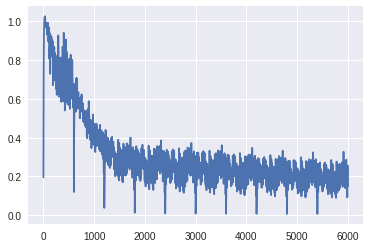

In [236]:
plt.plot(loss)

In [0]:
test_dataset = DSB2018Dataset_5D(TEST_DIR, test_ids, train=False)

In [0]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
from skimage.transform import resize
image_ids = []
rles = []
#starternet.cpu()
#albunet.cpu()
#starternet.eval()
#albunet.eval()

for test in test_dataset:
    #test_h = test[2]
    #test_w = test[3]
    
    batch_x = test[0]
    batch_x = Variable(batch_x).cuda()
    
    
    pred_i = starter_model(batch_x)[0, 0].data.cpu().numpy()
    
    #pred_i = np.expand_dims(pred_i, -1)
    #pred_i = np.swapaxes(pred_i, 0, -1)
    #pred_i = np.squeeze(pred_i)
    
    for rle in prob_to_rles(pred_i):
        image_ids.append(test[1])
        rles.append(rle)

In [0]:

submission = pd.DataFrame(data={'ImageId': image_ids,
                                'EncodedPixels': [' '.join(map(str, x)) for x in rles]})

In [55]:
submission.head(1)

,EncodedPixels,ImageId
0,2 28 520 33 567 24 1039 36 1083 28 1558 92 207...,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...


In [0]:
submission.to_csv(submission_path + '26' + submission_file, index=None)

In [0]:
!ls

0.csv  1.csv  bowl  data  datalab  drive  starterkit-2.csv  sub.csv


In [0]:
!cp starterkit-2.csv drive/bowl/submissions/